# Be able to put in posteriors from cue, get out some measure of the difference between the observed flux and what's predicted from the emulator for a set of emission lines

In [1]:
import numpy as np
import dill as pickle
import matplotlib
import corner
from matplotlib import pyplot as plt
from pkg_resources import resource_filename
from scipy.stats import gaussian_kde
from scipy import optimize
import cue
from cue.line import predict
from cue.utils import (c, cont_lam, new_sorted_line_name, 
                       logQ, Qtotal,
                       get_loglinear_spectra, ionparam2norm, calcQ) # this includes some constants and functions for the fits and output plots

"Necessary functions to use later"
# goodness of fit function for emission lines. 
# The noise here is only the observational noise, different than the one in likelihood function, where we also account for the emulator noise.
def chi_lines(fit, galaxy_data):
    "takes in a fit, like low_line or med_line, and calculates the chi for predicted - observed"
    "fit: predicted lines from the cloudy emulator"
    "observed_galaxy: observed fluxes, same as input to cue"
    "wav_ind_obs: indices in the line list of the observed lines in the galaxy"
    "wav_ind_up: indices in the line list of the lines we can use as limits in the galaxy"

    wav_ind, = np.where((galaxy_data['line_lum']!=0) | (galaxy_data['line_lum_up']!=0))
    wav_ind_obs, = np.where(galaxy_data['line_lum']!=0)  # indices where line is observed
    wav_ind_up, = np.where(galaxy_data['line_lum_up']!=0)



    chi = np.zeros_like(galaxy_data["line_lum"])
    chi[wav_ind_obs] = (fit[wav_ind_obs]-galaxy_data["line_lum"][wav_ind_obs]) / galaxy_data["line_lum_unc"][wav_ind_obs]
    chi[wav_ind_up] = (fit[wav_ind_up]-0) / galaxy_data["line_lum_unc"][wav_ind_up]
    
    chisq = np.sum(chi**2)
    ndof = len(chi[wav_ind])
    reduced_chisq = chisq/(ndof)

    percent_diff = np.zeros_like(galaxy_data["line_lum"])
    percent_diff[wav_ind_obs] = (fit[wav_ind_obs]-galaxy_data["line_lum"][wav_ind_obs]) / galaxy_data["line_lum"][wav_ind_obs]

    return reduced_chisq, chi, percent_diff

# define line labels of the emission lines for the plots
def formatNumber(num):
    if num % 1 == 0:
        return str(int(num))
    else:
        return str(num)
    
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')

round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))
# just formatting the x labels
shortened_sorted_line_name = list()
for i in range(len(new_sorted_line_name)):
    new_name = new_sorted_line_name[i][:5] + \
    formatNumber(round_to_n(float(new_sorted_line_name[i][5:12]), 4)) + \
    new_sorted_line_name[i][12]
    if new_name[-1] == 'A':
        new_name = new_name[:-1] + r'$\mathrm{\AA}$'
    if new_name[-1] == 'm':
        new_name = new_name[:-1] + r'$\mathrm{\mu}$m'
    shortened_sorted_line_name.append(new_name)
shortened_sorted_line_name = np.array(shortened_sorted_line_name)

cue_line_list = np.array(['H  1 923.150A', 'H  1 926.226A', 'H  1 930.748A', 'H  1 937.804A', 'H  1 949.743A', 'H  1 972.537A', 'H  1 1025.72A', 'H  1 1215.67A', 
                          'S  4 1406.02A', 'C  4 1548.19A', 'C  4 1550.77A', 'He 2 1640.41A', 'O  3 1660.81A', 'O  3 1666.15A', 'N  3 1750.00A', 'Ne 3 1814.56A',
                          'Al 3 1854.72A', 'Al 3 1862.79A', 'Si 3 1882.71A', 'Si 3 1892.03A','C  3 1906.68A', 'C  3 1908.73A', 'N  2 2142.77A', 'O  3 2320.95A', 
                          'C  2 2323.50A', 'C  2 2324.69A', 'C  2 2325.40A', 'C  2 2326.93A','C  2 2328.12A', 'Ne 4 2424.28A', 'O  2 2471.00A', 'Al 2 2660.35A',
                          'Al 2 2669.15A', 'Mg 2 2795.53A', 'Mg 2 2802.71A', 'Ar 3 3109.18A', 'Ne 3 3342.18A', 'S  3 3721.63A', 'O  2 3726.03A', 'O  2 3728.81A',
                          'H  1 3797.90A', 'H  1 3835.38A', 'Ne 3 3868.76A', 'He 1 3888.64A','H  1 3889.05A', 'Ne 3 3967.47A', 'H  1 3970.07A', 'S  2 4068.60A',
                          'S  2 4076.35A', 'H  1 4101.73A', 'H  1 4340.46A', 'O  3 4363.21A', 'He 1 4471.50A', 'C  1 4621.57A', 'He 2 4685.68A', 'Ar 4 4711.26A',
                          'Ne 4 4720.00A', 'Ar 4 4740.12A', 'H  1 4861.32A', 'O  3 4958.91A','O  3 5006.84A', 'Ar 3 5191.82A', 'N  1 5200.26A', 'Cl 3 5517.71A',
                          'Cl 3 5537.87A', 'O  1 5577.34A', 'N  2 5754.61A', 'He 1 5875.66A','O  1 6300.30A', 'S  3 6312.06A', 'O  1 6363.78A', 'N  2 6548.05A',
                          'H  1 6562.80A', 'N  2 6583.45A', 'He 1 6678.15A', 'S  2 6716.44A','S  2 6730.82A', 'He 1 7065.25A', 'Ar 3 7135.79A', 'O  2 7323.00A',
                          'O  2 7332.00A', 'Ar 4 7332.15A', 'Ar 3 7751.11A', 'Cl 2 8578.70A','C  1 8727.13A', 'H  1 9014.91A', 'S  3 9068.62A', 'Cl 2 9123.60A',
                          'H  1 9229.02A', 'S  3 9530.62A', 'H  1 9545.97A', 'C  1 9850.00A','H  1 1.00494m', 'S  2 1.03364m', 'He 1 1.08291m', 'He 1 1.08303m',
                          'H  1 1.09381m', 'Fe 2 1.25668m', 'H  1 1.28181m', 'H  1 1.73621m','H  1 1.81741m', 'H  1 1.87510m', 'H  1 1.94456m', 'H  1 2.16553m',
                          'H  1 2.62515m', 'H  1 3.03837m', 'H  1 3.29609m', 'H  1 3.73954m','H  1 4.05113m', 'H  1 4.65251m', 'H  1 5.12726m', 'H  1 5.90660m',
                          'Ar 2 6.98337m', 'H  1 7.45782m', 'H  1 7.50045m', 'Ar 3 8.98898m','S  4 10.5076m', 'H  1 12.3685m', 'Ne 2 12.8101m', 'Cl 2 14.3639m',
                          'Ne 3 15.5509m', 'S  3 18.7078m', 'Ar 3 21.8253m', 'P  2 32.8629m','S  3 33.4704m', 'Si 2 34.8046m', 'Ne 3 36.0036m', 'O  3 51.8004m',
                          'N  3 57.3238m', 'P  2 60.6263m', 'O  1 63.1679m', 'O  3 88.3323m','N  2 121.769m', 'O  1 145.495m', 'C  2 157.636m', 'N  2 205.283m',
                          'C  1 370.269m', 'C  1 609.590m'])

galaxy_names = ["BX216", "BX274", "BX336", "BX341", "BX348", "BX350", "BX390", "BX418", "BX429", "BX461", "BX474", "BX523", "BX587", "BX628", "D40", "fBM40", "fBM47", "fC23", "MD41"]

/tmp/ipykernel_1742996/793186844.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
2025-11-10 11:15:59.706493: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-10 11:15:59.711511: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 11:15:59.880986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 A

In [2]:
def get_linepredictions_forarun(galaxy, endtag):
    "Given a galaxy's results from cue, compute line predictions and deviations from observations for the galaxy"
    with open("cue-results/"+galaxy+"_results_"+endtag+"_stellar.pkl", 'rb') as f:
        cue_results = pickle.load(f)
    cue_results.keys()

    with open("line_luminosities/"+galaxy+".pkl", 'rb') as f:
        obs_gal = pickle.load(f)
    obs_gal.keys()

    # median and 1-sigma range of the emission line and nebular continuum
    from dynesty.utils import resample_equal
    theta_arr = resample_equal(cue_results.samples, np.exp(cue_results.logwt-cue_results.logz[-1]), rstate=None) 
                                 # resamples a set of points from the weighted set of inputs such that they all have equal weight
    line_preds = list()
    cont_pred = list()
    for ind in range(len(theta_arr)):
        # for literally every chain, 
        par = theta_arr[ind].copy()
        par[7] = logQ(par[7], lognH=par[8])  # convert U into the dimensional ionization parameter
        par[8] = 10**par[8]
        "predict the lines for every single point in the cue posteriors"
        line_preds.append(predict(theta=np.array(par[:12]).reshape(1, 12), 
                                line_ind=np.arange(138)).nn_predict()[1]/10**par[7]*10**par[12])     # based on the parameters in the theta array, predict lines
        cont_pred.append(cue.continuum.predict(theta=np.array(par[:12]).reshape(1, 12)).nn_predict()[1]/\
        10**par[7]*10**par[12])

    "get median and 16th and 84th percentile of the line predictions"
    low_line, med_line, up_line = np.quantile(np.array(line_preds), [0.16, 0.5, 0.84], axis=0)  # gets the 16% probability, median, and 84% probability
    #low_cont, med_cont, up_cont = np.quantile(np.array(cont_pred), [0.16, 0.5, 0.84], axis=0)

    "calculate chi of entire distribution, and then the chi for the median, low, and up line predictions"
    chi_preds = [chi_lines(i, obs_gal)[1] for i in line_preds]
    linechi_low = chi_lines(low_line, obs_gal)[1]
    linechi_up = chi_lines(up_line, obs_gal)[1]
    linechi_med = chi_lines(med_line, obs_gal)[1]      # gets the chi of the median predicted value of all the lines, basically 
    """IS THE CHI OF THE MEDIAN THE SAME AS THE MEDIAN OF THE CHI DISTRIBUTION???"""

    percentdiffs = [chi_lines(i, obs_gal)[2] for i in line_preds]
    percentdiff_low = chi_lines(low_line, obs_gal)[2]
    percentdiff_up = chi_lines(up_line, obs_gal)[2]
    percentdiff_med = chi_lines(med_line, obs_gal)[2]

    return line_preds, med_line, low_line, up_line, \
            chi_preds, linechi_med, linechi_low, linechi_up,  \
            percentdiffs, percentdiff_med, percentdiff_low, percentdiff_up

## get percent differences from all galaxies

In [ ]:
percentdiffs_allgalaxies = []
for galaxyname in galaxy_names:
    percent_diffs = get_linepredictions_forarun(galaxyname, "nolowion_noarsulf")[8]
    percentdiffs_allgalaxies.append(percent_diffs)

/tmp/ipykernel_1742996/793186844.py:32: RuntimeWarning: divide by zero encountered in divide
  chi[wav_ind_obs] = (fit[wav_ind_obs]-galaxy_data["line_lum"][wav_ind_obs]) / galaxy_data["line_lum_unc"][wav_ind_obs]


# function to plot distributions of line predictions for a specifed line, for each galaxy

In [ ]:
def get_distribution_anyline(distribution, linename):
    "get the median value (and 1st and 3rd quartile) of your chosen distribution (raw line prediction, chi, percent diffs) for a certain line"
    "todo: also get the max density point of the distribution"
    distribution = np.array(distribution)

    line_ind, = np.where(cue_line_list == linename)[0]

    line_distribution = distribution[:,line_ind]  # get all predictions (based on all posterior points) for a certain line
    quartile1, median, quartile3 = np.percentile(line_distribution, [25, 50, 75], axis=0)
    #plt.hist(line_distribution, density=True)

    #kernel = gaussian_kde(line_distribution, bw_method="scott")  # default bandwidth is scott

    # n_samples = len(line_distribution)
    # x_range = np.linspace(min(line_distribution),max(line_distribution), n_samples)
    # kde = kernel.evaluate(x_range)
    # plt.plot(x_range, kde)
    # plt.show()
    #opt = optimize.minimize_scalar(lambda x: -kernel(x))

    return line_distribution, np.float64(median), np.float64(quartile1), np.float64(quartile3) #, *opt.x


## function to plot violin plot for a certain line, for all galaxies 

In [ ]:
name_inds = np.arange(len(galaxy_names))
def plot_all_violins(list_for_some_line, line_name):

    "this function is so messed up lol, fix at some point"
    line_pred = [i[0] for i in list_for_some_line]
    meds = [i[1] for i in list_for_some_line]
    q1 = [i[2] for i in list_for_some_line]
    q3 = [i[3] for i in list_for_some_line]

    plt.figure(figsize=(12,4))
    plt.violinplot(line_pred)
    plt.scatter(name_inds+1, meds, marker = "s", zorder=5, color="tab:blue")
    plt.vlines(name_inds+1, q1, q3, color='black', linestyle='-', lw=2)
    plt.xticks(name_inds+1, labels=galaxy_names, rotation=90)
    plt.ylabel(line_name, fontsize=15)
    plt.ylim(min(q1)-(abs(min(q1))/2), max(q3)+(max(q3)/2))
    #plt.ylim(-10,60)
    plt.show()

# O1 and O3

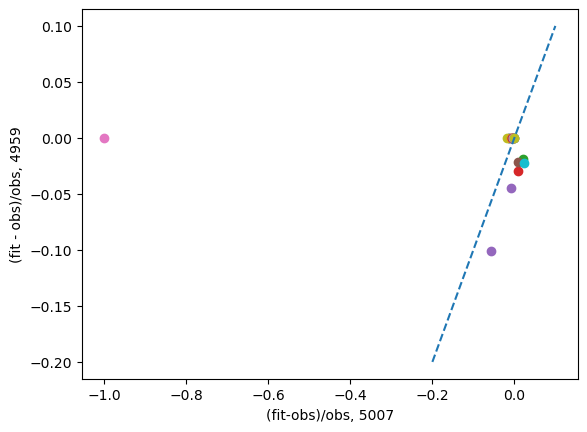

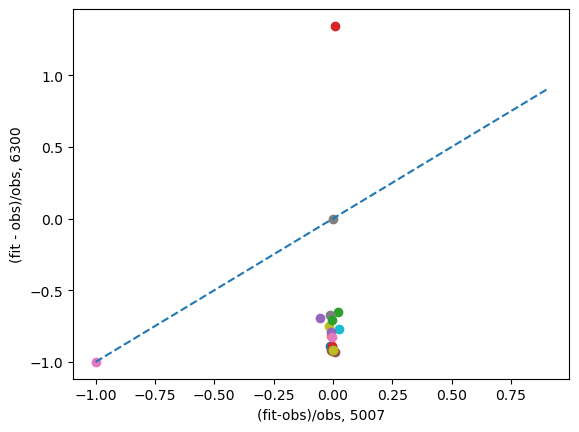

In [ ]:
o1_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, "O  1 6300.30A") for percent_diffs in percentdiffs_allgalaxies]
o3_4959_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, "O  3 4958.91A") for percent_diffs in percentdiffs_allgalaxies]
o3_5007_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, "O  3 5006.84A") for percent_diffs in percentdiffs_allgalaxies]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
for i in range(len(galaxy_names)):
    if o3_4959_deltas_all_galaxies[i][1] != 0:
        plt.scatter(o3_5007_deltas_all_galaxies[i][1], o3_4959_deltas_all_galaxies[i][1], label = galaxy_names[i])

plt.plot(np.arange(-0.2,0.1,0.1), np.arange(-0.2,0.1,0.1), ls = "--")
plt.xlabel("(fit-obs)/obs, 5007", fontsize=16)
plt.ylabel("(fit - obs)/obs, 4959", fontsize=14)
#plt.legend()
plt.subplot(1,2,2)

for i in range(len(galaxy_names)):
    plt.scatter(o3_5007_deltas_all_galaxies[i][1], o1_deltas_all_galaxies[i][1], label = galaxy_names[i])

plt.plot(np.arange(-1.0,1.0,0.1), np.arange(-1.0,1.0,0.1), ls = "--")
#plt.legend()
plt.xlabel("(fit-obs)/obs, 5007", fontsize=14)
plt.ylabel("(fit - obs)/obs, 6300", fontsize=14)
plt.show()

o3 deltas should be on the 1:1 line

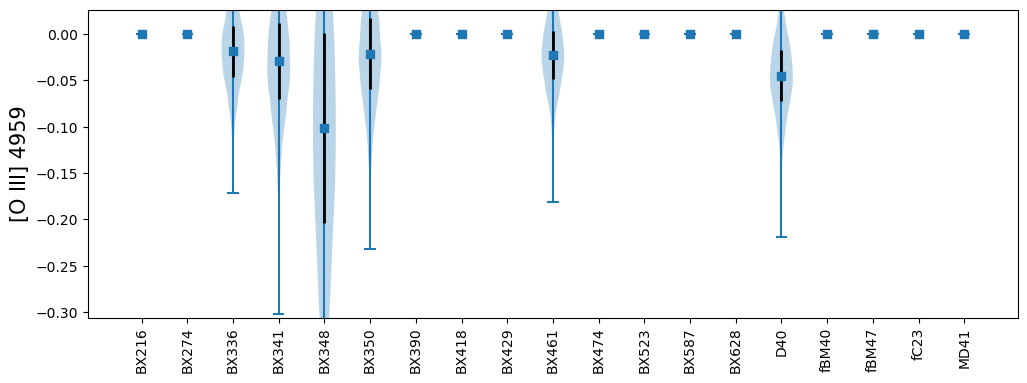

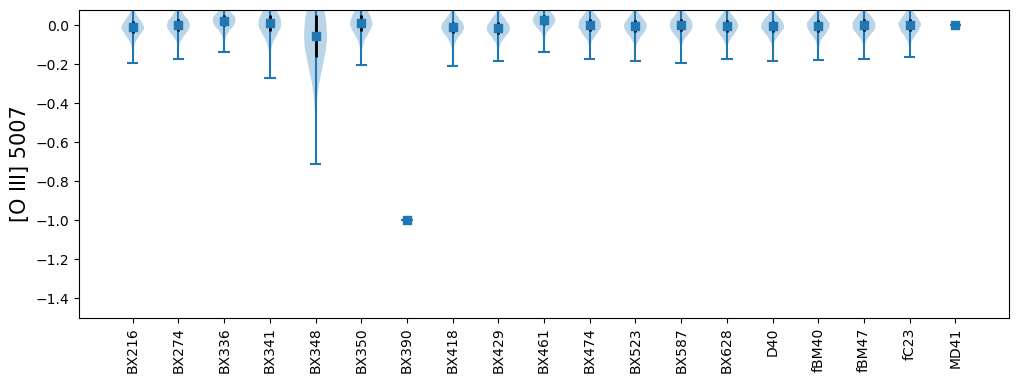

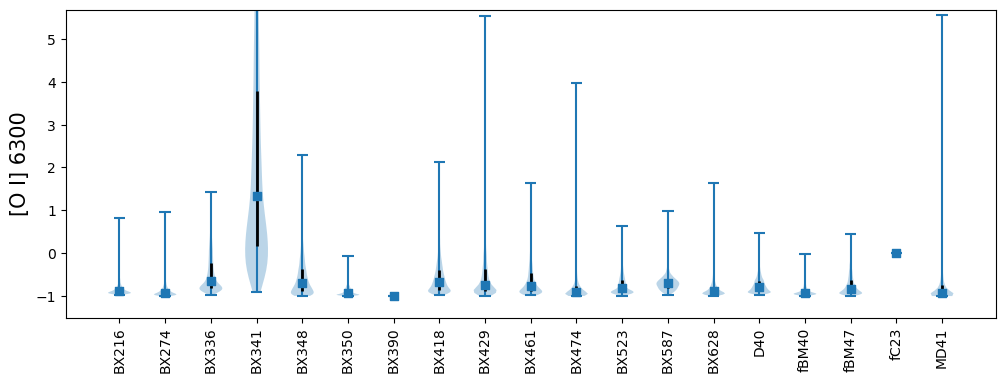

In [ ]:
plot_all_violins(o3_4959_deltas_all_galaxies, "[O III] 4959")
plot_all_violins(o3_5007_deltas_all_galaxies, "[O III] 5007")
plot_all_violins(o1_deltas_all_galaxies, "[O I] 6300")

# S2 and S3

In [ ]:
s2_6717_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, 'S  2 6716.44A') for percent_diffs in percentdiffs_allgalaxies]
s2_6731_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, 'S  2 6730.82A') for percent_diffs in percentdiffs_allgalaxies]
s3_9069_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, 'S  3 9068.62A') for percent_diffs in percentdiffs_allgalaxies]
s3_9531_deltas_all_galaxies = [get_distribution_anyline(percent_diffs, 'S  3 9530.62A') for percent_diffs in percentdiffs_allgalaxies]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("s2 comp")
for i in range(len(galaxy_names)):
    plt.scatter(s2_6717_deltas_all_galaxies[i][1], s2_6731_deltas_all_galaxies[i][1], label = galaxy_names[i])

plt.plot(np.arange(-0.2,0.1,0.1), np.arange(-0.2,0.1,0.1), ls = "--")
plt.xlabel("(fit-obs)/obs, 6717", fontsize=16)
plt.ylabel("(fit - obs)/obs, 6731", fontsize=14)
#plt.legend()
plt.subplot(1,2,2)
plt.title("s3 comp")
for i in range(len(galaxy_names)):
    plt.scatter(s3_9069_deltas_all_galaxies[i][1], s3_9531_deltas_all_galaxies[i][1], label = galaxy_names[i])

plt.plot(np.arange(-1.0,1.0,0.1), np.arange(-1.0,1.0,0.1), ls = "--")
#plt.legend()
plt.xlabel("(fit-obs)/obs, 9069", fontsize=14)
plt.ylabel("(fit - obs)/obs, 9531", fontsize=14)
plt.show()

# Plot delta s2 and delta s3 as a function of galaxy S/O